## 필요한 라이브러리, 패키지 로드 

In [1]:
import pandas as pd
import seaborn as sns 
import re
import numpy as np 
import io
from tqdm import trange, tqdm
from konlpy.tag import Okt
import tensorflow
okt=Okt()

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
# import keras

In [ ]:
!pip install konlpy
from konlpy.tag import Okt


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

## 파일 불러오기 ( fake_movies ) 

In [ ]:
from google.colab import files
myfile = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df1 = pd.read_csv('./div_movies_1.csv', encoding='utf-8')
df2 = pd.read_csv('./div_movies_2.csv', encoding='utf-8')
df3 = pd.read_csv('./div_movies_3.csv', encoding='utf-8')

In [ ]:
df = pd.concat([df1,df2,df3], ignore_index=True)
df.drop(columns='origin_index', inplace=True)
df

In [ ]:
df.isnull().sum()

# 데이터 전처리 (fake_movies)

## 정규표현식 이용해서 한글만 남기기, 정제 

결측행(np.nan) 없는 것 확인, 댓글이 '' 인 것 확인완료, 그러나 이 밑 작업 후 ''인 것 생길 것 -> 먼저 없애주고, 토큰화 진행할 것!

In [6]:
df['댓글']=df['댓글'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','') # 한글만 남기기
#df2['댓글']=df2['댓글'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','') # 한글만 남기기
#df3['댓글']=df3['댓글'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','') # 한글만 남기기

In [ ]:
from soynlp.normalizer import *

In [14]:
stem_reviews=[] #반복되는 'ㅋㅋㅋ'같은애들 정제해주기 

for stem in df['댓글']:
    temp1=emoticon_normalize(stem,num_repeats=2)
    stem_reviews.append(temp1)
    

TypeError: 'float' object is not iterable

In [ ]:
df['댓글']=stem_reviews #정제해준 애들 컬럼값으로 할당

## 불용어처리 & 단어토큰화 (fake_tokens)

In [ ]:
stop_words = ['지', '임', '게', '하', '고', '을', '인', '듯', '의', '가', '이',
             '은', '들', '는', '좀', '잘', '걍', '과', '와', '도', '를',
             '으로', '나','자', '에', '와', '네', '한', '하다', '았', '앗', '엇',
             '주', '되', '다', '따', '영','이', '걸', '만','즐','엔', '임', '후',
             '왠', '만','할','로','펌','무','적','원','치', '류','옆','타','함','구',
             '호','수','못','랑','요','씨','보고','대','됨','번','테','력','박','습',
             '라','데','옴','오','기','줌','않','함','그','거','로','도','은','는','들','에서','와','과','두','야']

In [10]:
# 이 타이밍에 정규표현식으로 인해 빈칸이 된 애들을 지워줍니다 !! 

index1=df[df['댓글']==''].index
df=df.drop(index1)

In [12]:
df=df.reset_index()
# 여기서 인덱스 리셋을 안해주니깐 밑에 포문에서 오류가 남

In [ ]:
# 이 타이밍에는, 불용어만 작성해서 이로 인해 빈칸이 될 애들을 미리 지워줍니다! 

for i in trange(len(df)):
    if df['댓글'][i] in stop_words:
        df=df.drop(i)
    else: continue

df=df.reset_index() #여기도 똑같이 오류 방지 

In [ ]:
review_tokens = []
for sent in df['댓글']:
    word_tokens = okt.morphs(sent) # 토큰화
    word_tokens = [word for word in word_tokens if not word in stop_words]
    review_tokens.append(word_tokens)  # 불용어 제거

In [ ]:
review_tokens

## 추가작업 & 확인 및 저장
여러 컬럼들을 비교하는 그래프를 그려보면서 데이터의 특징들을 찾아본다

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'NanumGothicCoding' 
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False


<AxesSubplot:xlabel='날짜차이', ylabel='댓글길이'>

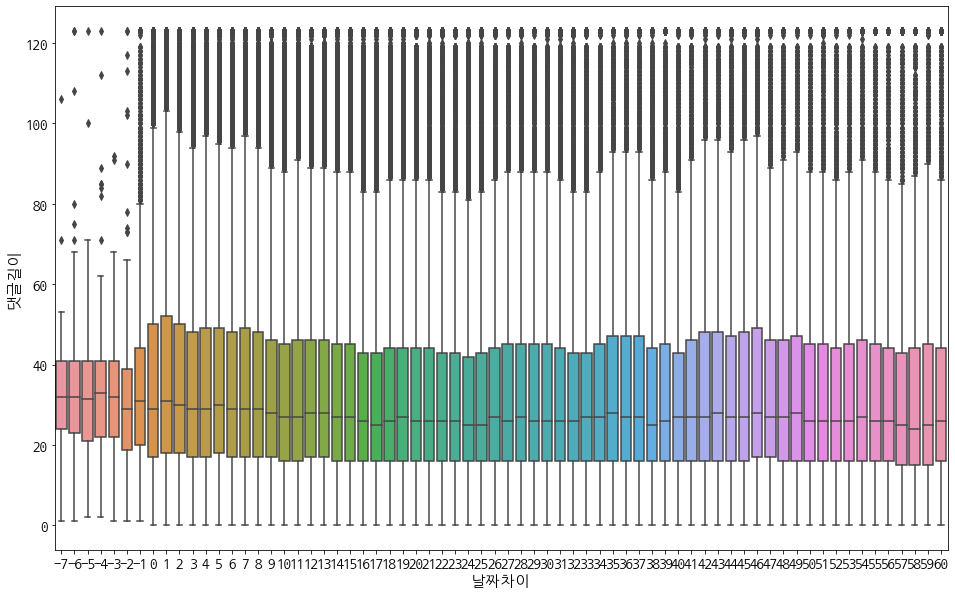

In [161]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df, x=df['날짜차이'] , y=df['댓글길이'])

In [148]:
df.groupby(by=['관람여부'])['댓글길이'].mean()

관람여부
0    40.789202
1    29.594445
Name: 댓글길이, dtype: float64

In [157]:
df['댓글길이']=df['댓글'].str.len()

In [160]:
df['댓글길이'].fillna(0, inplace=True)

In [154]:
df.drop(df[(df['날짜차이'] < -7) | (df['날짜차이'] > 60)].index, inplace=True)
df

,영화이름,개봉일,댓글번호,작성일자,댓글,평점,관람여부,스포여부,공감수,비공감수,공감차이,날짜차이,유저ID,영화코드
575,분노의_질주_언리미티드,2011-04-20 00:00:00,5489026,2011-06-19 17:14:00,매잼매잼,10,0,0,0,0,0,60,jinb****,74632
576,분노의_질주_언리미티드,2011-04-20 00:00:00,5482726,2011-06-15 19:39:00,액션이 정말 시원시원 하다,10,0,0,0,0,0,56,mook****,74632
577,분노의_질주_언리미티드,2011-04-20 00:00:00,5482458,2011-06-15 15:58:00,액션장면은 몰입도 최고,9,0,0,0,0,0,56,seip****,74632
578,분노의_질주_언리미티드,2011-04-20 00:00:00,5481782,2011-06-15 00:03:00,내생에 최고에 영화다 --; 극장에서 봤는데... 후반부엔 정말 할말없다.. 쩐다..;,10,0,0,0,0,0,56,ysms****,74632
579,분노의_질주_언리미티드,2011-04-20 00:00:00,5480391,2011-06-13 22:38:00,스토리는 별론데 액션이 최고임,10,0,0,0,0,0,54,pese****,74632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488717,관상,2013-09-11 00:00:00,7966234,2013-09-11 16:09:00,사극 별로안좋아하는데. 시간 가는지 모르게 잼나게 잘봤어요. 송강호 연기 잘하고 ...,10,0,0,2,4,-2,0,혁프린스(anth****),93728
2488718,관상,2013-09-11 00:00:00,7966139,2013-09-11 15:28:00,음 일단 기대 너무하진 말고 보시길.. 워낙 기대가 큰 작품이라.. 너무길어서 다소...,8,0,0,2,4,-2,0,시잉시잉(zzan****),93728
2488719,관상,2013-09-11 00:00:00,7966049,2013-09-11 14:45:00,"송강호 연기 쩔고 조정석과 호흡 좋음. 그러나 늘어지는 전개, 수양대군이 아닌 수양...",7,0,0,2,4,-2,0,하나의벗(laze****),93728
2488720,관상,2013-09-11 00:00:00,7966027,2013-09-11 14:36:00,"배우들 연기 잊을수가 없다,,, 최고의 걸작!",10,0,0,2,4,-2,0,jena****,93728


## 피클 저장
데이터가 너무 많아 로딩이 길고, 날짜 타입 경우 csv로 저장했다 불러올경우 자료형이 바뀌는 문제를 해결

In [ ]:
import pickle

In [ ]:
with open("movie2_tokens.pickle","wb") as f:
    pickle.dump(fake_tokens, f)

In [ ]:
with open("movie2_tokens.pickle","rb") as f:
    try_pickle = pickle.load(f)

In [ ]:
print(len(try_pickle))
print(len(fake_tokens))